In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

import zipfile
import pandas as pd
import os
from tqdm import tqdm


In [2]:
import os
import pandas as pd

path = 'ChengDuData'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

combined_dataframe = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    temp_df = pd.read_csv(file_path)
    
    # Compute the average travel time
    temp_df['Average_Travel_Time'] = temp_df.iloc[:, 8:59].mean(axis=1)
    
    # Extract time period information from file name
    time_period = file.replace('.csv', '').replace('_', ' ')
    temp_df['Time_Period'] = time_period

    # Select relevant columns (optional, depending on your model requirements)
    temp_df = temp_df[['Link', 'Node_Start', 'Longitude_Start', 'Latitude_Start', 
                       'Node_End', 'Longitude_End', 'Latitude_End', 'Length', 
                       'Average_Travel_Time', 'Time_Period']]
    
    combined_dataframe = pd.concat([combined_dataframe, temp_df], ignore_index=True)

# Now combined_dataframe contains the processed data


In [3]:
print(combined_dataframe.head())

   Link  Node_Start  Longitude_Start  Latitude_Start  Node_End  Longitude_End  \
0     0           0       103.946006       30.750660        16     103.952551   
1     1           0       103.946006       30.750660        48     103.956494   
2     2           0       103.946006       30.750660        64     103.941276   
3     3           1       104.062539       30.739077       311     104.060024   
4     4           1       104.062539       30.739077      1288     104.062071   

   Latitude_End       Length  Average_Travel_Time       Time_Period  
0     30.756752   921.041014            85.424151  Weekday Off peak  
1     30.745080  1179.207157           125.386769  Weekday Off peak  
2     30.754493   620.905375            53.618874  Weekday Off peak  
3     30.742693   467.552294            40.787167  Weekday Off peak  
4     30.732501   730.287581            77.209144  Weekday Off peak  


In [4]:
#haversine formula
from math import asin, cos, radians, sin, sqrt


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees).
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

Preprocessing

In [5]:
#Calculate distance and add it as a new feature
combined_dataframe['Distance'] = combined_dataframe.apply(lambda row: haversine(row['Longitude_Start'], row['Latitude_Start'],
                                                 row['Longitude_End'], row['Latitude_End']), axis=1)
# Features and targets
X = combined_dataframe[['Link', 'Node_Start', 'Longitude_Start', 'Latitude_Start', 'Node_End', 'Longitude_End', 'Latitude_End', 'Distance']].values
y = combined_dataframe['Average_Travel_Time'].values  # Assuming this is your target variable

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to torch tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y)

In [6]:
# Create Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
#Model Achitecture
class EnhancedTravelTimePredictor(nn.Module):
    def __init__(self):
        super(EnhancedTravelTimePredictor, self).__init__()
        self.fc1 = nn.Linear(8, 128)  # Adjust input features if necessary
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [8]:
#model instantiation
model = EnhancedTravelTimePredictor()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [9]:
#checkpoint saving
model_path = './model_checkpoints'
os.makedirs(model_path, exist_ok=True)
checkpoint_name = os.path.join(model_path, 'checkpoint_{epoch}.pth')

In [12]:
# change num_epochs here
from numpy import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error


num_epochs = 100
losses = []

#lists for logging metrics
train_mae = []
val_mae = []
train_rmse = []
val_rmse = []

# Training Loop with tqdm on the outer loop
for epoch in tqdm(range(num_epochs), desc='Training Progress', leave=True):
    model.train()
    train_loss = 0
    predictions, actuals = [], []

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(targets.tolist())
    
    # Calculate and log training MAE and RMSE
    train_mae.append(mean_absolute_error(actuals, predictions))
    train_rmse.append(sqrt(mean_squared_error(actuals, predictions)))

    
     # Logging
    if (epoch + 1) % 10 == 0:  # Adjust the logging frequency as needed
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}')


Training Progress:  10%|█         | 10/100 [00:20<02:57,  1.97s/it]

Epoch [10/100], Train Loss: 499.3563


Training Progress:  20%|██        | 20/100 [00:36<02:10,  1.63s/it]

Epoch [20/100], Train Loss: 486.6198


Training Progress:  30%|███       | 30/100 [00:52<01:48,  1.55s/it]

Epoch [30/100], Train Loss: 501.5391


Training Progress:  40%|████      | 40/100 [01:09<01:41,  1.69s/it]

Epoch [40/100], Train Loss: 489.3522


Training Progress:  50%|█████     | 50/100 [01:30<01:59,  2.39s/it]

Epoch [50/100], Train Loss: 487.5325


Training Progress:  60%|██████    | 60/100 [01:55<01:40,  2.51s/it]

Epoch [60/100], Train Loss: 497.6667


Training Progress:  70%|███████   | 70/100 [02:22<01:20,  2.69s/it]

Epoch [70/100], Train Loss: 487.2491


Training Progress:  80%|████████  | 80/100 [02:48<00:52,  2.65s/it]

Epoch [80/100], Train Loss: 481.6071


Training Progress:  90%|█████████ | 90/100 [03:14<00:24,  2.43s/it]

Epoch [90/100], Train Loss: 503.4497


Training Progress: 100%|██████████| 100/100 [03:41<00:00,  2.21s/it]

Epoch [100/100], Train Loss: 486.7075


In [14]:
# Save the model
path = 'models/'
# change name modle here
model_name = 'model2.pth'
torch.save(model.state_dict(), path + model_name)

In [15]:
# Evaluation
val_predictions, val_actuals = [], []
model.eval()
with torch.no_grad():
        for data, target in test_loader:  # Assuming test_loader is your validation set
            output = model(data)
            val_predictions.extend(output.view(-1).tolist())
            val_actuals.extend(target.tolist())
    
    # Calculate and log validation MAE and RMSE
        val_mae.append(mean_absolute_error(val_actuals, val_predictions))
        val_rmse.append(sqrt(mean_squared_error(val_actuals, val_predictions)))
        # Logging
        if (epoch + 1) % 10 == 0:  # Adjust the logging frequency as needed
         print(f'Train MAE: {train_mae[-1]:.4f}, Val MAE: {val_mae[-1]:.4f}')


Train MAE: 12.9345, Val MAE: 14.2762


In [16]:
# try the model with one data comparing the result with the real value

def try_single_prediction(test_loader, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Get a single batch from the test_loader
        data, target = next(iter(test_loader))
        # Select the first example from the batch
        single_data, single_target = data[0:1], target[0:1]
        # Predict
        prediction = model(single_data)
        # Print the results
        print(f'Actual value: {single_target.item()}')
        print(f'Predicted value: {prediction.item()}')
        # Optionally, you can return these values for further processing
        return single_target.item(), prediction.item()

# After training, try the model with one data point
actual, predicted = try_single_prediction(test_loader, model)

# Optionally, calculate the error for this single prediction
error = abs(actual - predicted)
print(f'Prediction error: {error}')

Actual value: 82.88508605957031
Predicted value: 55.270774841308594
Prediction error: 27.61431121826172


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

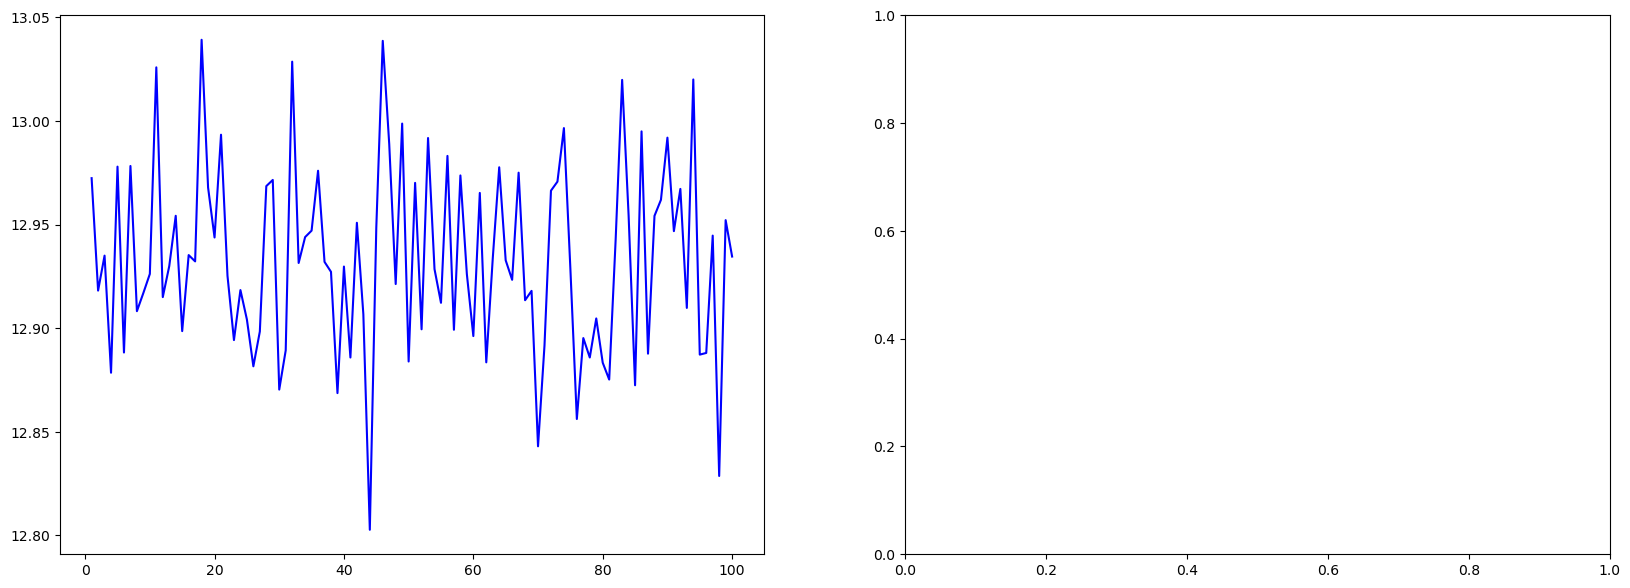

In [17]:
import matplotlib.pyplot as plt

# Plotting
epochs = range(1, len(train_mae) + 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# MAE Plot
ax[0].plot(epochs, train_mae, 'b', label='Training MAE')
ax[0].plot(epochs, val_mae, 'r', label='Validation MAE')
ax[0].set_title('Training and Validation MAE')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MAE')
ax[0].legend()

# RMSE Plot
ax[1].plot(epochs, train_rmse, 'b', label='Training RMSE')
ax[1].plot(epochs, val_rmse, 'r', label='Validation RMSE')
ax[1].set_title('Training and Validation RMSE')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('RMSE')
ax[1].legend()

plt.show()